# Isotropic damage

In [6]:
import matplotlib.pyplot as plt
import torch

from torchfem import Solid
from torchfem.materials import IsotropicDamage3D

from torchfem.mesh import cube_hexa


torch.set_default_dtype(torch.float64)

In [7]:
# Displacement
U = 0.1

# Elastic parameters (Young's modulus and Poisson's ratio)
E = 100e3
nu = 0.3

# Damage parameters (Damage initiation strain and fracture energy)
eps_0 = 0.005
G_f = 5.0


def d_kappa_lin(kappa, cl):
    # Final failure strain
    eps_f = 2 * G_f / (E * eps_0 * cl) + eps_0 / 2.0

    # Damage evolution law for linear strain softening
    evolution = (1 - eps_0 / kappa) * (eps_f / (eps_f - eps_0))
    evolution[kappa < eps_0] = 0.0
    evolution[kappa > eps_f] = 1.0

    return evolution


def d_kappa_exp(kappa, cl):
    # "Final" failure strain
    eps_e = G_f / (E * eps_0 * cl) + eps_0 / 2.0

    # Damage evolution law for exponential strain softening
    evolution = 1 - eps_0 / kappa * torch.exp(-(kappa - eps_0) / (eps_e - eps_0))
    evolution[kappa < eps_0] = 0.0

    return evolution


# Elastic properties
material_lin = IsotropicDamage3D(E, nu, d_kappa_lin, "rankine")
material_exp = IsotropicDamage3D(E, nu, d_kappa_exp, "rankine")

In [8]:
# Generate cube
nodes, elements = cube_hexa(5, 5, 5)

box_lin = Solid(nodes, elements, material_lin)
box_exp = Solid(nodes, elements, material_exp)

# Set constraints
box_lin.displacements[nodes[:, 0] == 1.0, 0] = U
box_lin.constraints[nodes[:, 0] == 0.0, 0] = True
box_lin.constraints[nodes[:, 0] == 1.0, 0] = True
box_lin.constraints[nodes[:, 1] == 0.5, 1] = True
box_lin.constraints[nodes[:, 2] == 0.5, 2] = True

# Set constraints
box_exp.displacements[nodes[:, 0] == 1.0, 0] = U
box_exp.constraints[nodes[:, 0] == 0.0, 0] = True
box_exp.constraints[nodes[:, 0] == 1.0, 0] = True
box_exp.constraints[nodes[:, 1] == 0.5, 1] = True
box_exp.constraints[nodes[:, 2] == 0.5, 2] = True

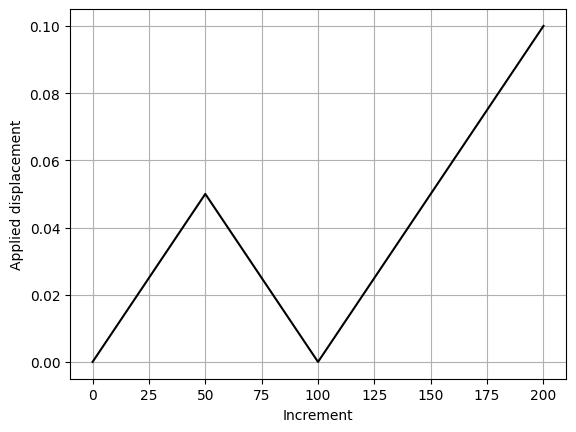

In [9]:
# Incremental loading
increments = torch.cat(
    (
        torch.linspace(0.0, 0.5, 51),
        torch.linspace(0.49, 0.0, 50),
        torch.linspace(0.01, 1.0, 100),
    )
)

plt.plot(increments * U, "k")
plt.xlabel("Increment")
plt.ylabel("Applied displacement")
plt.grid()
plt.show()

In [10]:
u_lin, f_lin, σ_lin, F_lin, α_lin = box_lin.solve(
    increments=increments, return_intermediate=True
)
u_exp, f_exp, σ_exp, F_exp, α_exp = box_exp.solve(
    increments=increments, return_intermediate=True
)

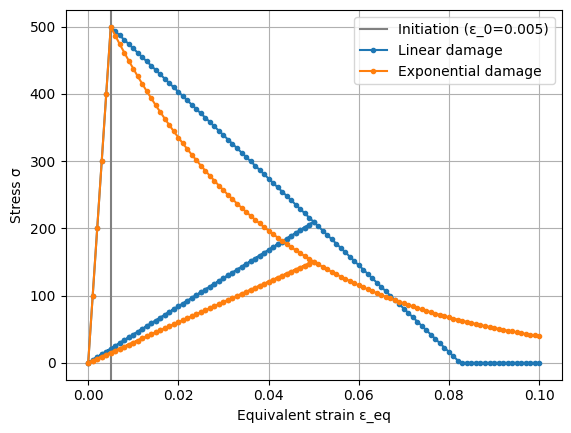

In [11]:
ε_lin = 0.5 * (F_lin.transpose(-1, -2) + F_lin) - torch.eye(3)
ε_exp = 0.5 * (F_exp.transpose(-1, -2) + F_exp) - torch.eye(3)


plt.axvline(eps_0, color="gray", label=f"Initiation (ε_0={eps_0})")
plt.plot(
    ε_lin[:, :, 0, 0].mean(dim=1),
    σ_lin[:, :, 0, 0].mean(dim=1),
    ".-",
    label=f"Linear damage",
)
plt.plot(
    ε_exp[:, :, 0, 0].mean(dim=1),
    σ_exp[:, :, 0, 0].mean(dim=1),
    ".-",
    label=f"Exponential damage",
)
plt.xlabel("Equivalent strain ε_eq")
plt.ylabel("Stress σ")
plt.grid()
plt.legend()
plt.show()